In [1]:
import os
import random
import cv2
from matplotlib import pyplot
import numpy
from keras.models import Model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.applications.xception import Xception
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

%matplotlib inline

Using TensorFlow backend.


# 数据预处理

首先查看数据的形式，包括训练集中数据的维度和label的形式。输出训练集中猫狗的数量，并随机输出了5个训练样本的图像，路径，维度和类型。

number of dogs: 12500
number of cats: 12500


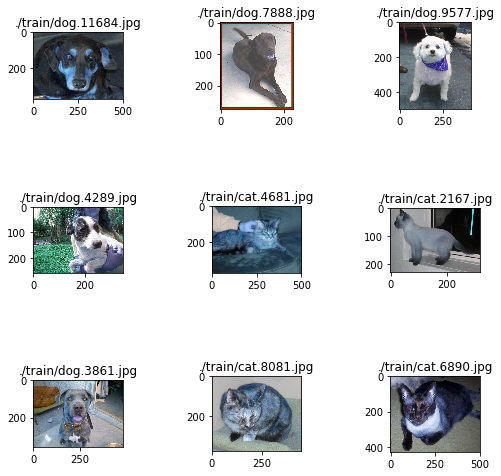

In [6]:
TRAIN_DIR = './train/'

train_path_list = [TRAIN_DIR + name for name in os.listdir(TRAIN_DIR)]

train_dogs = [path for path in train_path_list if 'dog' in path]
train_cats = [path for path in train_path_list if 'cat' in path]

dogs_num = len(train_dogs)
cats_num = len(train_cats)

print('number of dogs: {}'.format(dogs_num))
print('number of cats: {}'.format(cats_num))

def random_show(location):
    pyplot.subplot(location)
    sample = random.choice(train_path_list)
    image = cv2.imread(sample)
    pyplot.title(sample)
    pyplot.imshow(image)
    
pyplot.figure(figsize=(8,8))
pyplot.subplots_adjust(wspace=1, hspace=1)
for location in range(331, 340):
    random_show(location)
pyplot.show()

由以上可知，训练样本名字由：LABEL.ID.jpg 组成，但是每个样本的大小不同。

为了处理方便，需要统一数据维度。

所以先观察数据维度的分布，然后再决定统一的维度。

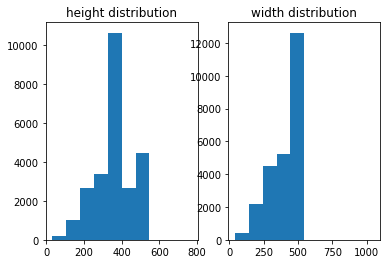

median of height: 374.0
median of width: 447.0


In [3]:
height = []
width = []

for path in train_path_list:
    image = cv2.imread(path)
    height.append(image.shape[0])
    width.append(image.shape[1])
    
pyplot.subplot(121)
pyplot.hist(height)
pyplot.title("height distribution")

pyplot.subplot(122)
pyplot.hist(width)
pyplot.title("width distribution")

pyplot.show()

print('median of height: {}'.format(numpy.median(height)))
print('median of width: {}'.format(numpy.median(width)))

由以上结果，将图片高、宽中位数为(374, 447)。

为了便于计算，将图片宽高缩放为256。

label采用独热编码，`dog: [1, 0], cat: [0, 1]`

将训练集以6:2:2的比例分为训练集，验证集和测试集。

In [4]:
SIZE = 256
SPLIT_TRAIN = 0.6
SPLIT_VAL = 0.8

def prepare_X(path_list):
    X = numpy.zeros((len(path_list), SIZE, SIZE, 3), dtype=numpy.uint8)
    
    for i, path in enumerate(path_list):
        image = cv2.imread(path)
        X[i] = cv2.resize(image, (SIZE, SIZE))
        
    return X

def prepare_y(path_list):
    y = numpy.zeros((len(path_list), 2), dtype=numpy.uint8)
    
    for i, path in enumerate(path_list):
        if 'dog' in path:
            y[i][0] = 1
        else:
            y[i][1] = 1
            
    return y

train_dogs_index = int(dogs_num * SPLIT_TRAIN)
train_cats_index = int(cats_num * SPLIT_TRAIN)

val_dogs_index = int(dogs_num * SPLIT_VAL)
val_cats_index = int(cats_num * SPLIT_VAL)

random.shuffle(train_dogs)
random.shuffle(train_cats)

training = train_dogs[:train_dogs_index] + train_cats[:train_cats_index]
random.shuffle(training)
X_train = prepare_X(training)
y_train = prepare_y(training)

validation = train_dogs[train_dogs_index:val_dogs_index] + train_cats[train_cats_index:val_cats_index]
random.shuffle(validation)
X_val = prepare_X(validation)
y_val = prepare_y(validation)

testing = train_dogs[val_dogs_index:] + train_cats[val_cats_index:]
random.shuffle(testing)
X_test = prepare_X(testing)
y_test = prepare_y(testing)

print('shape of X_train: {}'.format(X_train.shape))
print('shape of y_train: {}'.format(y_train.shape))
print('shape of X_val: {}'.format(X_val.shape))
print('shape of y_val: {}'.format(y_val.shape))
print('shape of X_test: {}'.format(X_test.shape))
print('shape of y_test: {}'.format(y_test.shape))

shape of X_train: (15000, 256, 256, 3)
shape of y_train: (15000, 2)
shape of X_val: (5000, 256, 256, 3)
shape of y_val: (5000, 2)
shape of X_test: (5000, 256, 256, 3)
shape of y_test: (5000, 2)


In [5]:
'''
# cv2.imread() normal
image1 = cv2.imread('./test1/10066.jpg')
print('image1: {}'.format(image1.shape))

# cv2.imread() error on ./test1/10067.jpg
image2 = cv2.imread('./test1/10067.jpg')
print('image2: {}'.format(image2.shape))
'''

image1: (375, 499, 3)


AttributeError: 'NoneType' object has no attribute 'shape'

# 搭建机器学习模型

Keras中提供了几个预训练的模型，其中Xception比较新且参数数量比较小，所以选择Xception模型和`imagenet`预训练权重进行训练。

为了适合本项目猫狗的二分类，将Xception模型的输出层改为二分类的全连接。

In [2]:
base_model = Xception(include_top=False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

NameError: name 'Xception' is not defined

将模型可视化

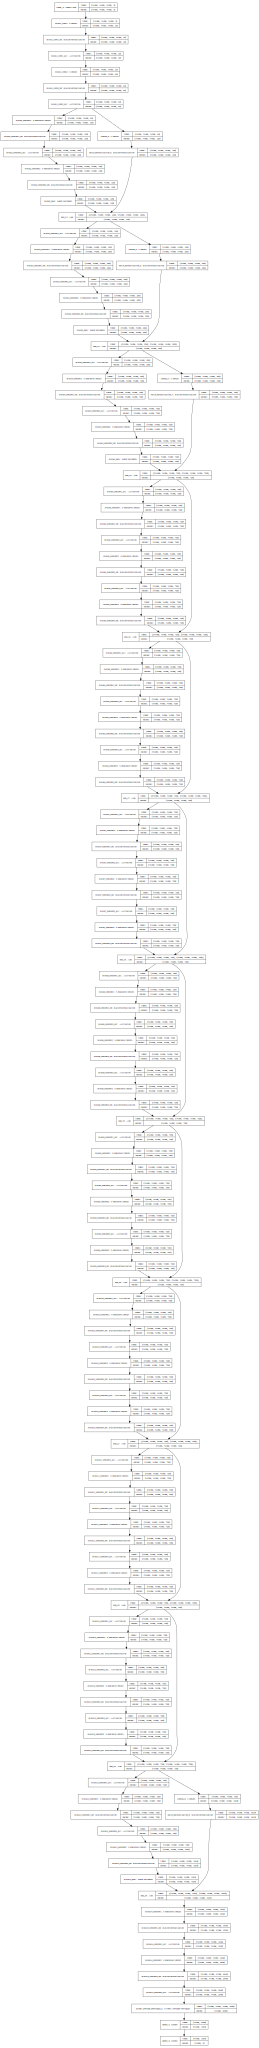

In [11]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

观察可知该模型结构合适。

微调输出层。

编译模型的优化器采用自适应的Nadam，损失函数采用对数随时函数binary_crossentropy，并计算精确值。

In [12]:
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer=Nadam(), loss='binary_crossentropy', metrics=['accuracy'])

训练模型。

为防止过拟合，val_loss不再下降后的3个epochs后停止训练

In [13]:
BATCH_SIZE = 128
EPOCHS = 10

earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')
CALLBACKS = [earlyStopping]

history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=CALLBACKS, validation_data=(X_val, y_val))

Train on 15000 samples, validate on 5000 samples
Epoch 1/10
15000/15000 [==============================] - 332s - loss: 0.1624 - acc: 0.9503 - val_loss: 0.8713 - val_acc: 0.7998
Epoch 2/10
15000/15000 [==============================] - 334s - loss: 0.0673 - acc: 0.9759 - val_loss: 1.1316 - val_acc: 0.7266
Epoch 3/10
15000/15000 [==============================] - 334s - loss: 0.0641 - acc: 0.9761 - val_loss: 0.0521 - val_acc: 0.9800
Epoch 4/10
15000/15000 [==============================] - 334s - loss: 0.0500 - acc: 0.9805 - val_loss: 0.0646 - val_acc: 0.9758
Epoch 5/10
15000/15000 [==============================] - 334s - loss: 0.0426 - acc: 0.9833 - val_loss: 0.0731 - val_acc: 0.9740
Epoch 6/10
15000/15000 [==============================] - 334s - loss: 0.0389 - acc: 0.9869 - val_loss: 0.0786 - val_acc: 0.9704
Epoch 7/10
15000/15000 [==============================] - 334s - loss: 0.0328 - acc: 0.9877 - val_loss: 0.0713 - val_acc: 0.9758


显示出loss随epoch变化的函数。

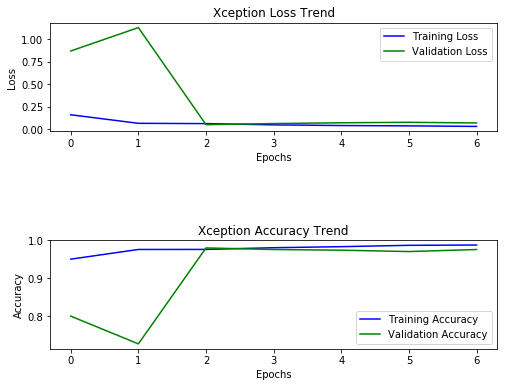

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

pyplot.figure(figsize=(8,6))
pyplot.subplots_adjust(wspace=1, hspace=1)

pyplot.subplot(211)
pyplot.plot(loss, 'blue', label='Training Loss')
pyplot.plot(val_loss, 'green', label='Validation Loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Xception Loss Trend')
pyplot.legend()

pyplot.subplot(212)
pyplot.plot(acc, 'blue', label='Training Accuracy')
pyplot.plot(val_acc, 'green', label='Validation Accuracy')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.title('Xception Accuracy Trend')
pyplot.legend()

pyplot.show()

# 对测试集进行预测并计算模型准确率

test loss:0.0871252275451
test accuracy:97.1%


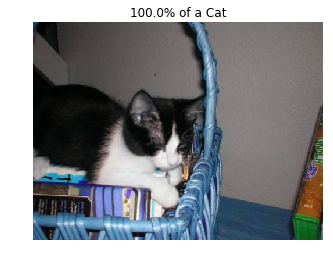

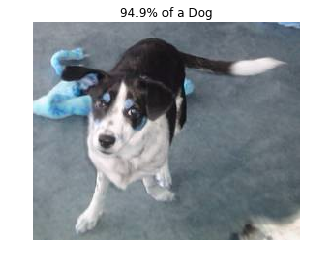

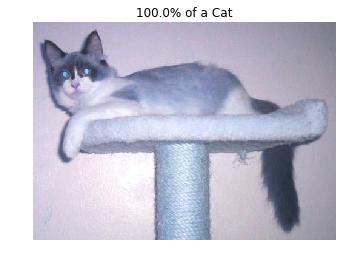

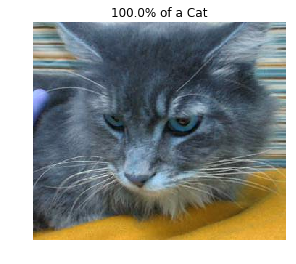

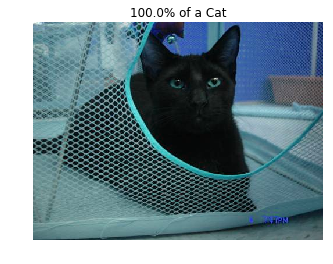

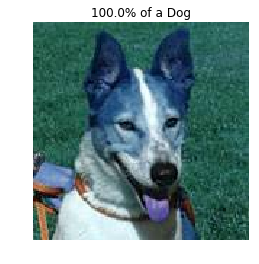

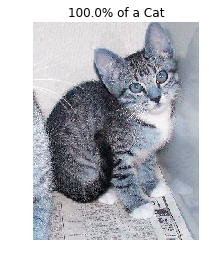

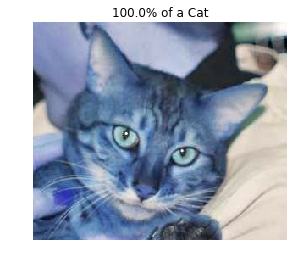

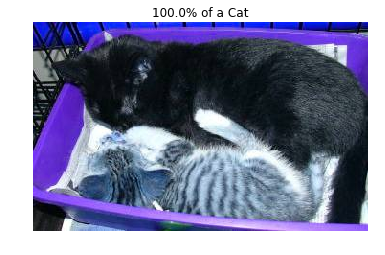

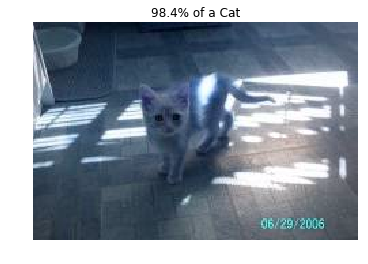

In [15]:
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
print('test loss:{}'.format(score[0]))
print('test accuracy:{:.1%}'.format(score[1]))

for i in range(10):
    index = random.randint(0, X_test.shape[0])
    
    x = numpy.expand_dims(X_test[index], axis=0)
    y = model.predict(x)
    
    if y[0, 0] > y[0, 1]: 
        title = '{:.1%} of a Dog'.format(y[0, 0])
    else: 
        title = '{:.1%} of a Cat'.format(y[0, 1])
    
    pyplot.title(title)
    image = cv2.imread(testing[index])
    pyplot.imshow(image)
    pyplot.axis('off')
    pyplot.show()

保存参数

In [ ]:
plot_model(model, to_file='./model.png')
model.save('./model.h5')